## 1.Overview of Semi-supervised Learning

### 1.Active Learning
--- Need extra label information from expert
#### a. Train a model with labeled data
#### b. Pick one unlabeled data, compare result with the result gained from the expert
#### c. Retrain the model with the information

### 2.Pure transductive Learning
--- No extra label from the expert
#### a. Train a model with both labeled and unlabeled data  
#### b. Use the model to predict new data

### 3.Transductive Learning
--- No extra label from the expert\n
#### a. Train a model with both labeled data  
#### b. Use the model to label unlabeled data

## 2. Models of semi-superviesed learning

#### 1.Generative methods 
EM methods --- need to know the distribution of the whole data

#### 2.Semi-Supervised Support Vector Machine S3VM
TSVM --- the objective function is not convex 

#### 3.Graph Semi-Supervised Learning
Label Propagation --- the quality of the graph matters

#### 4.Disagreement-based methods
Co-training --- combine with Ensemble Learning and  based on the design of basic learning machine

#### 5.More
Manifold regularization; S4VM (safe semi-supervised Learning)

## 3. Data prepartion for the models

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.svm as svm
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings('ignore')

In [39]:
from __future__ import print_function
from __future__ import division

In [40]:
## display all the columns
pd.options.display.max_columns = 120
pd.options.display.max_rows = 100

In [41]:
## one hot encoding methods
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# define example

def onehotencoding_fun(data):
    values = array(data)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    #print(integer_encoded)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    #print(onehot_encoded)
    # invert first example
    inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
    #print(inverted)
    return onehot_encoded 

In [94]:
df=pd.read_csv('data_onehot.csv')
df = df[df['Mark'] != 0]
df['Mark'].value_counts()

-1.0    1238
 1.0     354
Name: Mark, dtype: int64

In [312]:
data = np.array(df[['publisher_L','author_L','score_sentiment','magnitude_sentiment','tfidf','Mark']])
## shuffle the Mark
np.random.shuffle(data)

features = data[:,:-1]
label = data[:,-1]

for i in range(len(label)):
    if label[i] > 0:
        print(i)

0
1
2
3
7
20
23
31
45
55
56
58
61
63
66
67
71
74
76
77
78
84
85
93
94
97
98
101
103
110
114
115
117
124
126
134
143
147
152
156
159
163
165
169
182
184
192
193
202
205
206
212
213
216
219
226
229
233
242
248
262
266
268
272
273
277
279
281
288
292
293
294
299
304
306
308
312
313
318
322
325
329
331
337
339
341
344
350
354
357
364
371
375
384
385
387
394
402
403
410
411
414
419
422
430
431
432
437
444
452
468
473
475
481
490
495
498
510
511
517
519
523
533
535
537
540
543
549
551
556
559
564
569
580
583
593
595
598
608
613
621
625
628
634
635
638
650
652
653
656
664
668
675
677
685
688
692
708
714
717
723
734
740
751
752
755
771
775
776
779
794
801
806
808
813
814
817
819
824
828
833
839
840
842
844
845
858
863
867
871
877
878
881
895
906
908
910
911
915
916
919
926
927
932
933
949
951
954
956
957
964
967
968
969
980
983
993
995
996
1002
1004
1012
1027
1029
1030
1032
1033
1049
1051
1058
1060
1064
1065
1072
1080
1086
1094
1097
1098
1101
1111
1116
1119
1121
1124
1125
1129
1130
1132
1145
1

## 4. Codes for different models

## 1.Transductive support vector machines

In [296]:
## from 周志华 机器学习西瓜书
def TSVM_fun(l_d,l_c,u_d,test_d,test_c):
    lu_d = np.concatenate((l_d, u_d))
    n = len(l_d)+len(u_d)
    
    ## initialize SVM
    clf1 = svm.SVC(C=1,kernel='linear')
    clf1.fit(l_d, l_c)
    clf0 = svm.SVC(C=1,kernel='linear')
    clf0.fit(l_d, l_c)
    lu_c_0 = clf0.predict(lu_d) 
    
    # creating the p label for u_d
    u_c_new = clf1.predict(u_d)  
    cu, cl = 0.001, 1
    sample_weight = np.ones(n)
    sample_weight[len(l_c):] = cu
    id_set = np.arange(len(u_d))
    
    while cu < cl:
        lu_c = np.concatenate((l_c, u_c_new)) 
        clf1.fit(lu_d, lu_c, sample_weight=sample_weight)
        while True:
            u_c_new = clf1.predict(u_d)  # the p label for u_d
            u_dist = clf1.decision_function(u_d)  # the distance of each sample
            norm_weight = np.linalg.norm(clf1.coef_)  # norm of weight vector
            epsilon = 1 - u_dist * u_c_new * norm_weight

            plus_set, plus_id = epsilon[u_c_new > 0], id_set[u_c_new > 0]  # positive labelled samples
            ##check point1
            print(plus_set)
            minus_set, minus_id = epsilon[u_c_new < 0], id_set[u_c_new < 0]  # negative labelled samples
            ##check point1
            print(minus_set)
            plus_max_id, minus_max_id = plus_id[np.argmax(plus_set)], minus_id[np.argmax(minus_set)]
            a, b = epsilon[plus_max_id], epsilon[minus_max_id]

            if a > 0 and b > 0 and a + b > 2:
                u_c_new[plus_max_id], u_c_new[minus_max_id] = -u_c_new[plus_max_id], -u_c_new[minus_max_id]
                lu_c = np.concatenate((l_c, u_c_new))
                clf1.fit(lu_d, lu_c, sample_weight=sample_weight)
            else:
                break
        cu = min(cu * 2, cl)
        sample_weight[len(l_c):] = cu
    lu_c = np.concatenate((l_c, u_c_new))
    return lu_c_0,lu_d, lu_c, clf0, clf1

def caculateError(lu_c, label, start, end):
    lu_c = np.concatenate((lu_c[0:start], lu_c[end:]), axis = 0)
    label = np.concatenate((label[0:start], label[end:]), axis = 0)
    count = 0
    Label_len = len(lu_c)
    for i in range(Label_len):
        if lu_c[i] == label[i]:
            count += 1
    return count/Label_len

In [309]:
start , end = 450, 464
l_d, l_c = features[start:end], label[start:end] 
u_d = np.concatenate((features[0:start], features[end:1000]))
test_d, test_c = features[1000:], label[1000:]
lu_c_0,lu_d,lu_c, clf0,clf1 = TSVM_fun(l_d, l_c, u_d,test_d,test_c)
test_c1 = clf0.predict(test_d)
test_c2 = clf1.predict(test_d)
score1 = clf0.score(test_d,test_c)
score2 = clf1.score(test_d,test_c)

[-1.75251568e+00 -1.55986649e-02 -6.25058444e-02  2.13408949e-01
 -1.11333850e+00 -5.39554045e-01 -2.74626408e-02 -1.44700452e+00
 -6.38143703e-01  2.80089570e-01 -1.93540952e-02 -2.58503713e-02
 -1.77412205e+00 -1.67415393e-01  6.99366252e-01 -1.59302935e+00
  1.23781223e-01 -1.77527655e+00  9.13452623e-01  7.84405510e-01
 -1.76400515e+00 -1.49341155e-01 -9.50274056e-02 -3.20788173e-01
  5.11891737e-01 -1.51195783e+00 -1.21120015e+00  8.78748232e-01
 -5.79975104e-01  5.15467183e-01  6.53016669e-01 -1.20746489e-01
 -1.96343221e+00  3.77659789e-01  1.35297587e-01 -1.31325768e+00
  5.19218282e-01 -1.53606597e+00  2.64822331e-01 -1.06910784e+00
 -2.08423434e-01 -1.96094357e+00  9.29538548e-01 -4.81371403e-03
  2.57846184e-01  4.95139754e-01 -1.46781593e+00 -1.71940556e+00
 -1.35929970e+00 -3.88592849e-01  8.63183804e-01  1.39225500e-01
 -1.96533056e+00  3.84887915e-01 -1.24283864e+00  5.70413029e-01
 -7.81519841e-01  4.50278945e-01 -1.20892926e-01  6.67191743e-01
 -6.25058444e-02 -6.74703

  0.52377814 -0.40226732]
[-0.99968758 -4.99938641 -4.99971738 -0.9998536  -0.9997689  -4.9999521
 -0.99994454 -0.99985449 -4.99977041 -4.99973135 -4.99937853 -1.0000742
 -4.99992031 -4.99931108 -4.99998001 -4.9993373  -0.99937523 -4.99976669
 -4.9993298  -4.99938583 -4.99977725 -4.99971398 -0.99968356 -0.99969561
 -0.99973218 -4.99920909 -4.99999435 -4.99932679 -0.99941641 -0.99969733
 -4.9995266  -4.99958406 -0.99950463 -4.99950329 -4.99962019 -0.99970884
 -4.99978305 -0.99968038 -4.99931848 -4.99960012 -0.9999416  -4.9993811
 -0.99949489 -0.99971709 -4.99981928 -4.99985873 -4.9995273  -0.9996227
 -0.99989079 -4.99970641 -4.99994419 -4.99936957 -0.99971014 -4.99935149
 -0.99992538 -0.9998536  -1.00011317 -0.99962142 -1.00015298 -4.99981567
 -4.99996314 -4.9995136  -4.999955   -0.9996728  -4.99948412 -4.99978404
 -0.99968016 -0.99973275 -0.99973821 -4.9997325  -4.99975787 -4.99978383
 -4.99935795 -0.99972279 -4.99985667 -4.99944614 -4.9996409  -0.99966634
 -0.99969016 -4.99977425 -4.9

In [310]:
score1

0.4341216216216216

In [311]:
score2

0.4206081081081081

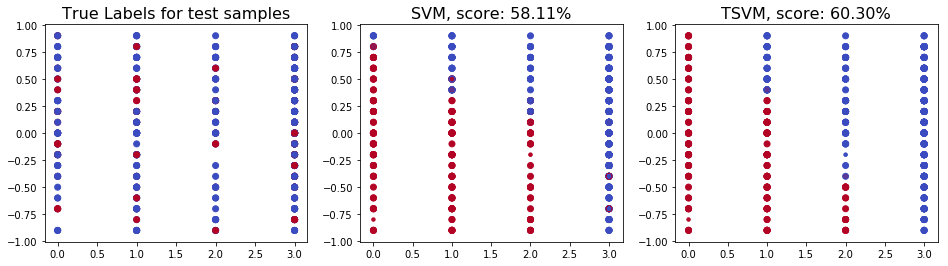

In [232]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(131)
ax.scatter(test_d[:,0],test_d[:,2],c=test_c,marker='o',cmap=plt.cm.coolwarm)
ax.set_title('True Labels for test samples',fontsize=16)
ax1 = fig.add_subplot(132)
ax1.scatter(test_d[:,0],test_d[:,2],c=test_c1,marker='o',cmap=plt.cm.coolwarm)
ax1.scatter(lu_d[:,0], lu_d[:,2], c=lu_c_0, marker='o',s=10,cmap=plt.cm.coolwarm,alpha=.6)
ax1.set_title('SVM, score: {0:.2f}%'.format(score1*100),fontsize=16)
ax2 = fig.add_subplot(133)
ax2.scatter(test_d[:,0],test_d[:,2],c=test_c2,marker='o',cmap=plt.cm.coolwarm)
ax2.scatter(lu_d[:,0], lu_d[:,2], c=lu_c, marker='o',s=10,cmap=plt.cm.coolwarm,alpha=.6)
ax2.set_title('TSVM, score: {0:.2f}%'.format(score2*100),fontsize=16)
plt.show()


## 2.Label propagation

In [165]:
# coding=utf8
"""
Graph-Based Semi-Supervised Learning (GBSSL) implementation.
"""

# Authors: Yuto Yamaguchi <yamaguchi.yuto@aist.go.jp>
# Lisence: MIT

import numpy as np
from scipy import sparse
from abc import ABCMeta, abstractmethod
from sklearn.base import BaseEstimator, ClassifierMixin

class Base(BaseEstimator, ClassifierMixin):
    __metaclass__ = ABCMeta
    def __init__(self,graph,max_iter=30):
        self.max_iter = max_iter
        self.graph = graph

    @abstractmethod
    def _build_propagation_matrix(self):
        raise NotImplementedError("Propagation matrix construction must be implemented to fit a model.")

    @abstractmethod
    def _build_base_matrix(self):
        raise NotImplementedError("Base matrix construction must be implemented to fit a model.")

    def _init_label_matrix(self):
        n_samples = self.graph.shape[0]
        n_classes = self.y_.max()+1
        return np.zeros((n_samples,n_classes))

    def _arrange_params(self):
        """Do nothing by default"""
        pass

    def fit(self,x,y):
        """Fit a graph-based semi-supervised learning model
        All the input data is provided array X (labeled samples only)
        and corresponding label array y.
        Parameters
        ----------
        x : array_like, shape = [n_labeled_samples]
            Node IDs of labeled samples
        y : array_like, shape = [n_labeled_samples]
            Label IDs of labeled samples
        Returns
        -------
        self : returns an instance of self.
        """
        self.x_ = x
        self.y_ = y

        self._arrange_params()

        self.F_ = self._init_label_matrix()

        self.P_ = self._build_propagation_matrix()
        self.B_ = self._build_base_matrix()

        remaining_iter = self.max_iter
        while remaining_iter > 0:
            self.F_ = self._propagate()
            remaining_iter -= 1

        return self

    def _propagate(self):
        return self.P_.dot(self.F_) + self.B_

    def predict(self,x):
        """Performs prediction based on the fitted model
        Parameters
        ----------
        x : array_like, shape = [n_samples]
            Node IDs
        Returns
        -------
        y : array_like, shape = [n_samples]
            Predictions for input node IDs
        """
        probas = self.predict_proba(x)
        return np.argmax(probas,axis=1)

    def predict_proba(self,x):
        """Predict probability for each possible label
        Parameters
        ----------
        x : array_like, shape = [n_samples]
            Node IDs
        Returns
        -------
        probabilities : array_like, shape = [n_samples, n_classes]
            Probability distributions across class labels
        """
        z = np.sum(self.F_[x], axis=1)
        z[z==0] += 1 # Avoid division by 0
        return (self.F_[x].T / z).T


class LGC(Base):
    """Local and Global Consistency (LGC) for GBSSL
    Parameters
    ----------
    alpha : float
      clamping factor
    max_iter : float
      maximum number of iterations allowed
    Attributes
    ----------
    x_ : array, shape = [n_samples]
        Input array of node IDs.
    References
    ----------
    Zhou, D., Bousquet, O., Lal, T. N., Weston, J., & Schölkopf, B. (2004).
    Learning with local and global consistency.
    Advances in neural information processing systems, 16(16), 321-328.
    """

    def __init__(self,graph=None,alpha=0.99,max_iter=30):
        super(LGC, self).__init__(graph,max_iter=30)
        self.alpha=alpha

    def _build_propagation_matrix(self):
        """ LGC computes the normalized Laplacian as its propagation matrix"""
        degrees = self.graph.sum(axis=0).A[0]
        degrees[degrees==0] += 1  # Avoid division by 0
        D2 = np.sqrt(sparse.diags((1.0/degrees),offsets=0))
        S = D2.dot(self.graph).dot(D2)
        return self.alpha*S

    def _build_base_matrix(self):
        n_samples = self.graph.shape[0]
        n_classes = self.y_.max()+1
        B = np.zeros((n_samples,n_classes))
        B[self.x_,self.y_] = 1
        return (1-self.alpha)*B

class HMN(Base):
    """Harmonic funcsion (HMN) for GBSSL
    Parameters
    ----------
    max_iter : float
      maximum number of iterations allowed
    Attributes
    ----------
    x_ : array, shape = [n_samples]
        Input array of node IDs.
    References
    ----------
    Zhu, X., Ghahramani, Z., & Lafferty, J. (2003, August).
    Semi-supervised learning using gaussian fields and harmonic functions.
    In ICML (Vol. 3, pp. 912-919).
    """
    def __init__(self,graph=None,max_iter=30):
        super(HMN, self).__init__(graph,max_iter=30)

    def _build_propagation_matrix(self):
        degrees = self.graph.sum(axis=0).A[0]
        degrees[degrees==0] += 1  # Avoid division by 0
        D = sparse.diags((1.0/degrees),offsets=0)
        P = D.dot(self.graph).tolil()
        P[self.x_] = 0
        return P.tocsr()

    def _build_base_matrix(self):
        n_samples = self.graph.shape[0]
        n_classes = self.y_.max()+1
        B = np.zeros((n_samples,n_classes))
        B[self.x_,self.y_] = 1
        return B

class PARW(Base):
    """Partially Absorbing Random Walk (PARW) for GBSSL
    Parameters
    ----------
    lamb: float (default=0.001)
      Absorbing parameter
    max_iter : float
      maximum number of iterations allowed
    Attributes
    ----------
    x_ : array, shape = [n_samples]
        Input array of node IDs.
    References
    ----------
    Wu, X. M., Li, Z., So, A. M., Wright, J., & Chang, S. F. (2012).
    Learning with partially absorbing random walks.
    In Advances in Neural Information Processing Systems (pp. 3077-3085).
    """
    def __init__(self,graph=None,lamb=1.0,max_iter=30):
        super(PARW, self).__init__(graph,max_iter=30)
        self.lamb=lamb

    def _build_propagation_matrix(self):
        d = self.graph.sum(axis=1).T.A[0]
        Z = sparse.diags(1.0 / (d+self.lamb), offsets=0)
        P = Z.dot(self.graph)
        return P

    def _build_base_matrix(self):
        n_samples = self.graph.shape[0]
        n_classes = self.y_.max()+1
        B = np.zeros((n_samples,n_classes))
        B[self.x_,self.y_] = 1
        d = np.array(self.graph.sum(1).T)[0]
        Z = sparse.diags(1.0 / (d+self.lamb), offsets=0)
        Lamb = sparse.diags(self.lamb,shape=(n_samples,n_samples), offsets=0)
        return Z.dot(Lamb).dot(B)

class OMNI(Base):
    """OMNI-Prop for GBSSL
    Parameters
    ----------
    lamb : float > 0 (default = 1.0)
      Define importance between prior and evidence from neighbors
    max_iter : float
      maximum number of iterations allowed
    Attributes
    ----------
    x_ : array, shape = [n_samples]
        Input array of node IDs.
    References
    ----------
    Yamaguchi, Y., Faloutsos, C., & Kitagawa, H. (2015, February).
    OMNI-Prop: Seamless Node Classification on Arbitrary Label Correlation.
    In Twenty-Ninth AAAI Conference on Artificial Intelligence.
    """

    def __init__(self,graph=None,lamb=1.0,max_iter=30):
        super(OMNI,self).__init__(graph,max_iter)
        self.lamb = lamb

    def _build_propagation_matrix(self):
        d = self.graph.sum(axis=0).A[0]
        dT = self.graph.sum(axis=1).T.A[0]
        Q = (sparse.diags(1.0/(d+self.lamb), offsets=0).dot(self.graph)).dot(sparse.diags(1.0/(dT+self.lamb),offsets=0).dot(self.graph.T)).tolil()
        Q[self.x_] = 0
        return Q

    def _build_base_matrix(self):
        n_samples = self.graph.shape[0]
        n_classes = self.y_.max()+1
        unlabeled = np.setdiff1d(np.arange(n_samples),self.x_)

        dU = self.graph[unlabeled].sum(axis=1).T.A[0]
        dT = self.graph.sum(axis=0).A[0]
        n_samples = self.graph.shape[0]
        r = sparse.diags(1.0/(dU+self.lamb),offsets=0).dot(self.lamb*self.graph[unlabeled].dot(sparse.diags(1.0/(dT+self.lamb),offsets=0)).dot(np.ones(n_samples))+self.lamb)

        b = np.ones(n_classes) / float(n_classes)

        B = np.zeros((n_samples,n_classes))
        B[unlabeled] = np.outer(r,b)
        B[self.x_,self.y_] = 1
        return B

class CAMLP(Base):
    """Confidence-Aware Modulated Label Propagation (CAMLP) for GBSSL
    Parameters
    ----------
    beta : float > 0 (default = 0.1)
      Define importance between prior and evidence from neighbors
    H : array_like, shape = [n_classes, n_classes]
      Define affinities between labels
      if None, identity matrix is set
    max_iter : float
      maximum number of iterations allowed
    Attributes
    ----------
    x_ : array, shape = [n_samples]
        Input array of node IDs.
    References
    ----------
    Yamaguchi, Y., Faloutsos, C., & Kitagawa, H. (2016, May).
    CAMLP: Confidence-Aware Modulated Label Propagation.
    In SIAM International Conference on Data Mining.
    """

    def __init__(self,graph=None,beta=0.1,H=None,max_iter=30):
        super(CAMLP,self).__init__(graph,max_iter)
        self.beta=beta
        self.H=H

    def _arrange_params(self):
        if self.H is None:
            n_classes = self.y_.max()+1
            self.H = np.identity(n_classes)
        self.Z = self._build_normalization_term()

    def _propagate(self):
        return self.P_.dot(self.F_).dot(self.H) + self.B_

    def _build_normalization_term(self):
        d = self.graph.sum(axis=1).T.A[0]
        return sparse.diags(1.0/(1.0+d*self.beta),offsets=0)

    def _build_propagation_matrix(self):
        return self.Z.dot(self.beta*self.graph)

    def _build_base_matrix(self):
        n_samples = self.graph.shape[0]
        n_classes = self.y_.max()+1
        B = np.ones((n_samples,n_classes))/float(n_classes)
        B[self.x_] = 0
        B[self.x_,self.y_] = 1
        return self.Z.dot(B)